# pusab

In [1]:
import json

# with open('pusab2024/result.json') as f:
with open('sup/pusab/result.json') as f:
    my_json = json.load(f)

In [2]:
import pandas as pd
my_keys = set()
emojis = set()
hashtags = set()
for message in my_json['messages']:
    if pd.to_datetime(message['date']) < pd.to_datetime("2024-08-06"):
        my_keys = my_keys.union(set(message.keys()))
        if ('reactions' in message) and (len(message['reactions']) >0):
            for rxn in message['reactions']:
                emojis.add(rxn['emoji'])
        if ('text_entities' in message) and (len(message['text_entities'] )> 0):
            hashtags = hashtags.union(set([i['text'] for i in message['text_entities'] if i['type']=='hashtag']))


In [3]:
import pandas as pd
from collections import defaultdict
import numpy as np

res_dict = defaultdict(list)
emoji_dict = defaultdict(list)
hashtag_dict = defaultdict(list)

for message in my_json['messages']:
    
    if (pd.to_datetime(message['date']) < pd.to_datetime("2024-08-06")) and (pd.to_datetime(message['date']) > pd.to_datetime("2024-01-01")) and (message['type']=='message'):
        for k, v in message.items():
            res_dict[k].append(str(v))
        text_plain = ''.join([i['text'] for i in message['text_entities'] if (i['type']!='hashtag') and (i['type']!='mention')])
        if ('photo' in message) and (pd.notnull(message['photo'])):
            text_plain = "media_image\n" + text_plain
        if ('media_type' in message):
            if message['media_type'] == 'video_file':
                text_plain = "media_video\n" + text_plain
            if message['media_type'] == 'voice_message':
                text_plain = "media_audio\n" + text_plain
        res_dict['text_plain'].append(text_plain)
        un_list = [i for i in my_keys if i not in message]
        for i in un_list:
            res_dict[i].append(np.nan)
        
        temp_emojis = dict()
        emoji_dict['id'].append(message['id'])
        if ('reactions' in message) and (len(message['reactions']) > 0):
            temp_emojis = {i['emoji']:i['count'] for i in message['reactions']}
        
        for k, v in temp_emojis.items():
            emoji_dict[k].append(v)
        un_emojis = [i for i in emojis if i not in temp_emojis]
        for i in un_emojis:
            emoji_dict[i].append(np.nan)
        
        temp_hashs = set()
        hashtag_dict['id'].append(message['id'])
        if ('text_entities' in message) and (len(message['text_entities']) > 0):
            for j in [i['text'] for i in message['text_entities'] if i['type']=='hashtag']:
                if j not in temp_hashs:
                    temp_hashs.add(j)
                    hashtag_dict[j].append(1)
        un_hashs = [i for i in hashtags if i not in temp_hashs]
        for i in un_hashs:
            hashtag_dict[i].append(np.nan)

In [4]:
result_df = pd.DataFrame(res_dict)
result_df = result_df[result_df['text_plain'].apply(len)>0].reset_index(drop=True)
result_df['id'] = result_df['id'].astype(int)
result_df['date'] = pd.to_datetime(result_df['date'])

emoji_df = pd.DataFrame(emoji_dict)
emoji_df['id'] = emoji_df['id'].astype(int)

hashtag_df = pd.DataFrame(hashtag_dict)
hashtag_df['id'] = hashtag_df['id'].astype(int)


result_df['num_reactions'] = result_df['id'].map(emoji_df.set_index('id').sum(axis=1).to_dict())

result_df['Reactions'] = result_df['id'].map(emoji_df.set_index('id').apply(lambda x: "Reactions: " + " ".join([i+str(int(v)) for i, v in x.sort_values(ascending=False).items() if pd.notna(v)]), axis=1))
result_df['Text_Emotion'] = (result_df['text_plain'] + " " + result_df['Reactions']).str.strip()

result_df['image_address'] = result_df['photo'].apply(lambda x: 'sup/pusab/' + x if pd.notnull(x) else np.nan)

result_df['weights'] = np.sqrt(result_df['num_reactions']+1).astype(int)

In [5]:
from bnlp import NLTKTokenizer, BengaliCorpus
from bangla_stemmer.stemmer.stemmer import BanglaStemmer
import os
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from contextlib import redirect_stdout

snowball_stemmer = nltk.stem.SnowballStemmer('english')

stemmer = BanglaStemmer()

# bnltk_tokenizer = NLTKTokenizer()
twt_tokenizer = TweetTokenizer()

ignore_words = stopwords.words('english') + BengaliCorpus.stopwords + list(BengaliCorpus.punctuations) + ['➡', "", "click", "..", "..."]

def process_texts(x):
    x = x.lower().replace("।", "")
    
    nltk_tokens = twt_tokenizer.tokenize(x)
    filtered_nltk_tokens = [i for i in nltk_tokens if (i not in ignore_words) and (len(i.strip())> 1)]
    # filtered_tokens = [i for i in stemmed_tokens if i not in BengaliCorpus.stopwords]
    stemmed_tokens = [snowball_stemmer.stem(i) for i in filtered_nltk_tokens]
    # x = " ".join(stemmed_tokens)
    
    
    # tokens = bnltk_tokenizer.word_tokenize(x)
    
    with open(os.devnull, 'w') as f:
        with redirect_stdout(f):
            stemmed_tokens = [stemmer.stem(i) for i in stemmed_tokens]
    
    return [i for i in stemmed_tokens if len(i) >0]



result_df['documents'] = result_df['text_plain'].apply(process_texts)


result_df['documents']=result_df['documents'].apply(lambda x: [i for i in x if len(i)>1])


punkt not found. downloading...


[nltk_data] Downloading package punkt_tab to /home/fahim/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
/home/fahim/miniconda3/envs/llm_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel, CoherenceModel


result_df_subset = result_df[result_df['documents'].apply(len)>0].reset_index(drop=True)

dictionary = Dictionary(result_df_subset['documents'])


weighted_corpus = []
for i, text in enumerate(result_df_subset['documents']):
    bow = dictionary.doc2bow(text)
    weighted_bow = []
    for word_id, count in bow:
        weighted_bow.append((word_id, count * result_df_subset['weights'].iloc[i]))
    weighted_corpus.append(weighted_bow)

lda_model = LdaModel(weighted_corpus, 3, id2word=dictionary)

print(lda_model.log_perplexity(weighted_corpus))

cohere_model = CoherenceModel(model=lda_model, corpus=weighted_corpus, dictionary=dictionary, coherence='u_mass')
print(cohere_model.get_coherence())
lda_model.print_topics()

-7.345345366271304
-3.670465661331132


[(0,
  '0.017*"আপনা" + 0.008*"ঢাকা" + 0.008*"সকল" + 0.007*"শিক্ষার্থী" + 0.006*"ছাত্র" + 0.006*"দিয়ে" + 0.006*"কর" + 0.006*"করুন" + 0.005*"অনুরোধ" + 0.005*"আন্দোলন"'),
 (1,
  '0.007*"শিক্ষার্থী" + 0.007*"সকল" + 0.007*"আপনা" + 0.006*"univers" + 0.006*"সাথে" + 0.006*"ঢাকা" + 0.006*"আন্দোলন" + 0.005*"ছাত্র" + 0.005*"হয়" + 0.005*"আস"'),
 (2,
  '0.012*"media_imag" + 0.009*"media_video" + 0.008*"শিক্ষার্থী" + 0.007*"আপনা" + 0.007*"আগামীকাল" + 0.007*"উত্ত" + 0.006*"ছাত্র" + 0.006*"হয়" + 0.006*"সবা" + 0.006*"এক"')]

(array([19929., 19931., 19933., 19935., 19936., 19938., 19940.]),
 [Text(19929.0, 0, '2024-07-25'),
  Text(19931.0, 0, '2024-07-27'),
  Text(19933.0, 0, '2024-07-29'),
  Text(19935.0, 0, '2024-07-31'),
  Text(19936.0, 0, '2024-08-01'),
  Text(19938.0, 0, '2024-08-03'),
  Text(19940.0, 0, '2024-08-05')])

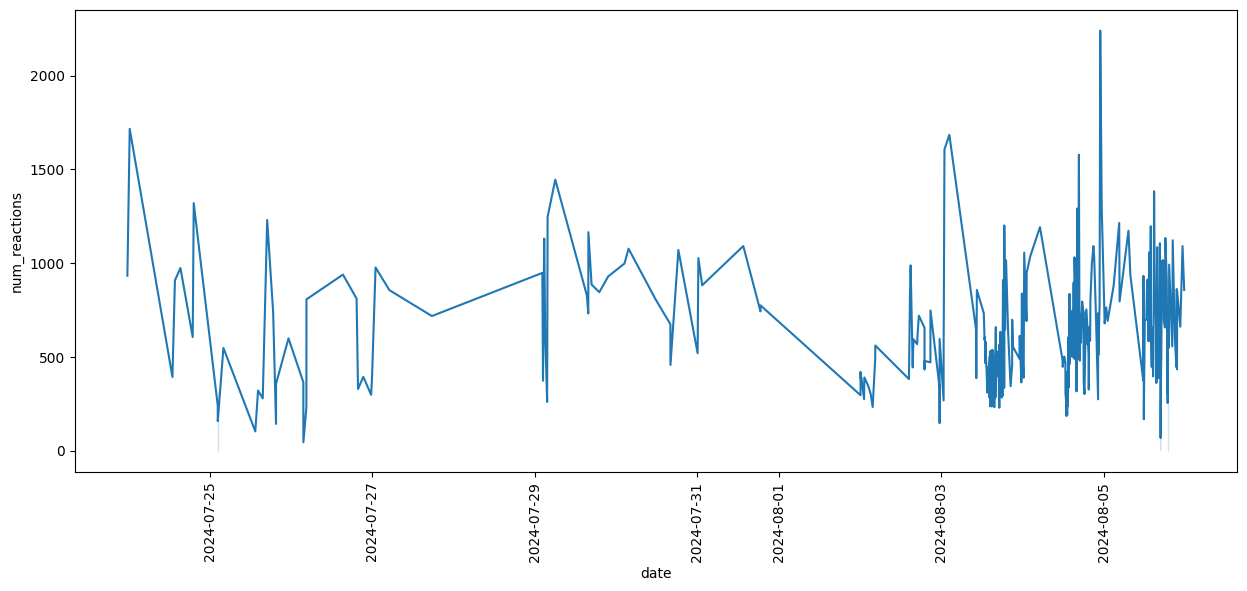

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15,6))
sns.lineplot(x=result_df['date'], y=result_df['num_reactions'] )
plt.xticks(rotation=90,)

In [8]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# Visualize the topics
pyLDAvis.enable_notebook()
p = gensimvis.prepare(lda_model, weighted_corpus, dictionary)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.061465 -0.010937       1        1  38.169500
2      0.040940 -0.043921       2        1  31.060805
1      0.020524  0.054858       3        1  30.769695, topic_info=             Term         Freq        Total Category  logprob  loglift
394    media_imag  1219.000000  1219.000000  Default  30.0000  30.0000
395   media_video   900.000000   900.000000  Default  29.0000  29.0000
1043         উত্ত   867.000000   867.000000  Default  28.0000  28.0000
406            এক   685.000000   685.000000  Default  27.0000  27.0000
308       univers   829.000000   829.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
1021       uttara   186.951177   490.726247   Topic3  -5.9495   0.2136
397          করুন   236.847855   991.956564   Topic3  -5.7129  -0.2536
394    media_imag   219.219642  1219.991783   Topic3  -5.7902  -0.5379
928           নাম   182.839251   610.481372   Topic3  -5.9717  -0.0270
189           দেশ   183.488380   639.108240   Topic3  -5.9681  -0.0693

[299 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
3453      3  0.967136          10
3250      3  0.955210  aftabnagar
3212      1  0.019854     airport
3212      2  0.039709     airport
3212      3  0.933157     airport
...     ...       ...         ...
2921      1  0.040371    হয়েছেএখন
2921      3  0.928541    হয়েছেএখন
1129      1  0.277538          ১১
1129      2  0.426802          ১১
1129      3  0.296196          ১১

[557 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

In [9]:
result_df_subset['text_plain'].str.contains('media_').sum()

103

In [10]:
len(result_df_subset)

394

In [11]:
result_df_subset['from'].value_counts()

from
PUSAB    394
Name: count, dtype: int64

In [12]:
result_df.to_csv('myfolder/pusab_main.csv', index=False)
emoji_df.to_csv('myfolder/pusab_emoji.csv', index=False)

In [12]:
result_df['image_address'].notna().sum()

61

In [13]:
from openai import OpenAI
from dotenv import load_dotenv
import json
import io
from PIL import Image, ImageOps
import base64

load_dotenv()

def count_openai_embedding_tokens(text: str) -> int:
    """Counts the number of tokens in a text string for OpenAI embedding models."""
    encoding = tiktoken.get_encoding("cl100k_base")
    num_tokens = len(encoding.encode(text))
    return num_tokens


system_prompt = """You are an expert emotion analysis AI. Your task is to analyze the provided Telegram post and identify the **primary Ekman emotion** expressed.

The Ekman emotions you must choose from are:
- **Anger**: Feeling of antagonism provoked by ill-treatment or opposition.
- **Disgust**: Feeling of revulsion or strong disapproval aroused by something unpleasant or offensive.
- **Fear**: Unpleasant emotion caused by the belief that someone or something is dangerous, likely to cause pain, or a threat.
- **Happiness**: State of well-being and contentment; joy.
- **Sadness**: Emotional pain associated with, or characterized by, feelings of disadvantage, loss, despair, grief, helplessness, disappointment, and sorrow.
- **Surprise**: Feeling caused by something unexpected or unusual.

Please analyze the following telegram post and provide the primary Ekman emtion.

**If the primary emotion doesn't match any of the Ekman emotion then please provide the closest emotion outside the Ekman classification.

If no emotion could be found at all, then please return 'NA'."""

# system_prompt = """You are an expert emotion analysis AI. Your task is to analyze the provided Telegram post and identify the **primary Ekman emotion** expressed.

# The Ekman emotions you must choose from are:
# - **Anger**: Feeling of antagonism provoked by ill-treatment or opposition.
# - **Disgust**: Feeling of revulsion or strong disapproval aroused by something unpleasant or offensive.
# - **Fear**: Unpleasant emotion caused by the belief that someone or something is dangerous, likely to cause pain, or a threat.
# - **Happiness**: State of well-being and contentment; joy.
# - **Sadness**: Emotional pain associated with, or characterized by, feelings of disadvantage, loss, despair, grief, helplessness, disappointment, and sorrow.
# - **Surprise**: Feeling caused by something unexpected or unusual.

# Please analyze the following telegram post and return the dominant Ekman emotion in structured JSON format. If no emotion could be found, then please return 'N/A'. In addition to the emotion label, provide a short explanation for why this emotion was identified.

# Format your output as a valid JSON object with the following fields:
# {
#   "explanation": "<brief explanation (1-2 sentences) of which Ekman emotion is most dominant in the post>"
#   "emotion": "<one of: Anger, Disgust, Fear, Happiness, Sadness, Surprise, N/A>",
# }
# Ensure the output is strictly valid JSON."""


# response_format = {
#     "type": "json_schema",
#     "name": "ekman_emotion",
#     "schema": {
#         "type": "object",
#         "properties": {
#             "emotion": {
#                 "type": "string",
#                 "description": "The primary Ekman emotion expressed in the text.",
#                 "enum": [
#                     "Anger",
#                     "Disgust",
#                     "Fear",
#                     "Happiness",
#                     "Sadness",
#                     "Surprise",
#                     "NA",
#                 ],
#             }
#         },
#         "required": ["emotion"],
#         "additionalProperties": False,
#     },
#     "strict": True,
# }

tool = [
      {
        "type": "function",
        "function": {
          "name": "classify_ekman_emotion",
          "description": "Classify the dominant Ekman emotion from a Telegram post",
          "parameters": {
            "type": "object",
            "properties": {
              "explanation": {
                "type": "string",
                "description": "A brief explanation for which Ekman emotion is dominant"
              },
              "emotion": {
                "type": "string",
                # "enum": [
                #     "Anger",
                #     "Disgust",
                #     "Fear",
                #     "Happiness",
                #     "Sadness",
                #     "Surprise",
                #     "NA",
                # ],
                "description": "The dominant Ekman emotion"
              },
            },
            "required": ["explanation", "emotion"]
          }
        }
      }
    ]

my_texts = ["some text", "Doesn't look fun at all", "some other text", "This is so fun"]

# with open("my_test.jsonl", "w") as f:
#     for i, x in enumerate(my_texts):
#         json.dump(
#             {
#                 "custom_id": f"random_id{i}",
#                 "method": "POST",
#                 "url": "/v1/chat/completions",
#                 "body": {
#                     "model": "gpt-4.1-nano",
#                     "messages": [
#                         {"role": "system", "content": system_prompt},
#                         {"role": "user", "content": x},
#                     ],
#                 "tools":tool,
#                 "tool_choice":'required'
                
#                 },
#             },
#             f,
#         )
#         f.write("\n")

with open("pusab.jsonl", "w") as f:
    for _, row in result_df.iterrows():
    # for i, x in enumerate(my_texts):
        if pd.isnull(row['image_address']):
          json.dump(
              {
                  "custom_id": f"pusab_{row['id']}",
                  "method": "POST",
                  "url": "/v1/chat/completions",
                  "body": {
                      "model": "gpt-4.1-nano",
                      "messages": [
                          {"role": "system", "content": system_prompt},
                          {"role": "user", "content": row['Text_Emotion']},
                      ],
                  "tools":tool,
                  "tool_choice":'required'
                  
                  },
              },
              f,
          )
        else:
          img = Image.open(row['image_address'])
          
          min_size = min(img.size)
          buffer = io.BytesIO()
          if min_size > 128:
            img_small = ImageOps.scale(img, 128/min_size)
            img_small.save(buffer, format="jpeg")
          else:
            img.save(buffer, format='jpeg')



          encoded_img = base64.b64encode(buffer.getvalue()).decode("utf-8")
          
          json.dump(
              {
                  "custom_id": f"pusab_{row['id']}",
                  "method": "POST",
                  "url": "/v1/chat/completions",
                  "body": {
                      "model": "gpt-4.1-nano",
                      "messages": [
                          {"role": "system", "content": system_prompt},
                          {"role": "user", "content": [{"type":"text", "text":row['Text_Emotion']},
                                                       {"type":"image_url", "image_url": {"url": f"data:image/jpeg;base64,{encoded_img}"}}]},
                      ],
                  "tools":tool,
                  "tool_choice":'required'
                  
                  },
              },
              f,
          )
        f.write("\n")

client = OpenAI()


In [14]:
batch_input_file = client.files.create(
    file=open("pusab.jsonl", "rb"), purpose="batch"
)

print(batch_input_file)

FileObject(id='file-XxMnrq9PtMcf6wCVhDjGJz', bytes=1628947, created_at=1751712880, filename='pusab.jsonl', object='file', purpose='batch', status='processed', expires_at=None, status_details=None)


In [15]:
batch_input_file_id = batch_input_file.id

client.batches.create(
    input_file_id=batch_input_file_id,
    endpoint="/v1/chat/completions",
    completion_window="24h",
    metadata={"description": "Pusab emotion analysis"},
)

Batch(id='batch_68690477ef788190a1452cbe5de8956d', completion_window='24h', created_at=1751712887, endpoint='/v1/chat/completions', input_file_id='file-XxMnrq9PtMcf6wCVhDjGJz', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1751799287, failed_at=None, finalizing_at=None, in_progress_at=None, metadata={'description': 'Pusab emotion analysis'}, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0))

In [20]:
client.batches.retrieve('batch_68690477ef788190a1452cbe5de8956d')

Batch(id='batch_68690477ef788190a1452cbe5de8956d', completion_window='24h', created_at=1751712887, endpoint='/v1/chat/completions', input_file_id='file-XxMnrq9PtMcf6wCVhDjGJz', object='batch', status='completed', cancelled_at=None, cancelling_at=None, completed_at=1751714092, error_file_id=None, errors=None, expired_at=None, expires_at=1751799287, failed_at=None, finalizing_at=1751713832, in_progress_at=1751712889, metadata={'description': 'Pusab emotion analysis'}, output_file_id='file-V4eCq4y5LLe9nXsyd3wEaU', request_counts=BatchRequestCounts(completed=394, failed=0, total=394))

In [21]:
file_response = client.files.content('file-V4eCq4y5LLe9nXsyd3wEaU')

In [23]:
my_res_dict = defaultdict(list)

for i in file_response.iter_lines():
    # print(i)
    # break
    my_res_dict['id'].append(int(json.loads(i)['custom_id'].split("_")[-1]))
    j = json.loads(json.loads(i)['response']['body']['choices'][0]['message']['tool_calls'][0]['function']['arguments'])
    try:
        my_res_dict['ekman_emotion'].append(j['emotion'])
    except:
        print(j)
        my_res_dict['ekman_emotion'].append('NA')
        
    my_res_dict['emotion_explanation'].append(j['explanation'])
    # print(j['emotion'], j['explanation'])

{'explanation': 'The post describes a scenario where the person is entering a bike event with a large group, which seems to invoke a feeling of annoyance or anger, especially considering the reactions including a high number of angry emoji (🤬).'}


In [24]:
pd.DataFrame(my_res_dict)['ekman_emotion'].value_counts()

ekman_emotion
Happiness                                                 181
Anger                                                      97
Fear                                                       49
Sadness                                                    46
NA                                                          8
Surprise                                                    7
Disgust                                                     5
Encouragement and motivation likely reflect Happiness.      1
Name: count, dtype: int64

In [25]:
pd.DataFrame(my_res_dict).to_csv('pusab_emotion.csv', index=False)